<font size='5'><h1 ><center> **Detecting COVID-19 in X-ray images with Keras, TensorFlow, and Deep Learning : VGG-19 Transfer Learning**</center></h1></font>

### **Overview**
Our project employs Transfer Learning with VGG16 architecture and pre-trained ImageNet weights in Keras with TensorFlow backend for automated COVID-19 detection using X-ray images from our dataset.


---

In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.68GB
Available: 11.88GB
Used: 544.18MB
Percentage: 6.3%


In [2]:
! nvidia-smi

Mon Oct  9 04:12:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **Data preprocessing and exploring**

### Access Files in Drive

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


### Import required libraries and necessary packages

In [4]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time

import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications import VGG19
from keras.layers import AveragePooling2D, MaxPool2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix


### Load The data

In [5]:
# The path of our data on drive
data_dir =  r'/gdrive/MyDrive/COVID-19-Detection-From-X-Ray-master/data/X-Ray Image DataSet'

# Loading Data
data = load_files(data_dir)

In [6]:
folders=os.listdir("/gdrive/MyDrive/COVID-19-Detection-From-X-Ray-master/data/X-Ray Image DataSet")
print(folders)

['No_findings', 'Covid-19']


In [7]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /gdrive/MyDrive/COVID-19-Detection-From-X-Ray-master/data/X-Ray Image DataSet/No_findings/00002550_000.png
Target labels -  1
Number of training files :  625
Number of training targets :  625


### Convert images to arrays

In [8]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)

        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape)
print('First training item : ',X[0])

(625, 224, 224, 3)
First training item :  [[[35. 35. 35.]
  [32. 32. 32.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 [[30. 30. 30.]
  [26. 26. 26.]
  [26. 26. 26.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [23. 23. 23.]]

 [[22. 22. 22.]
  [22. 22. 22.]
  [24. 24. 24.]
  ...
  [22. 22. 22.]
  [23. 23. 23.]
  [22. 22. 22.]]

 ...

 [[24. 24. 24.]
  [27. 27. 27.]
  [55. 55. 55.]
  ...
  [67. 67. 67.]
  [78. 78. 78.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [25. 25. 25.]
  [41. 41. 41.]
  ...
  [76. 76. 76.]
  [82. 82. 82.]
  [78. 78. 78.]]

 [[21. 21. 21.]
  [30. 30. 30.]
  [25. 25. 25.]
  ...
  [77. 77. 77.]
  [81. 81. 81.]
  [73. 73. 73.]]]


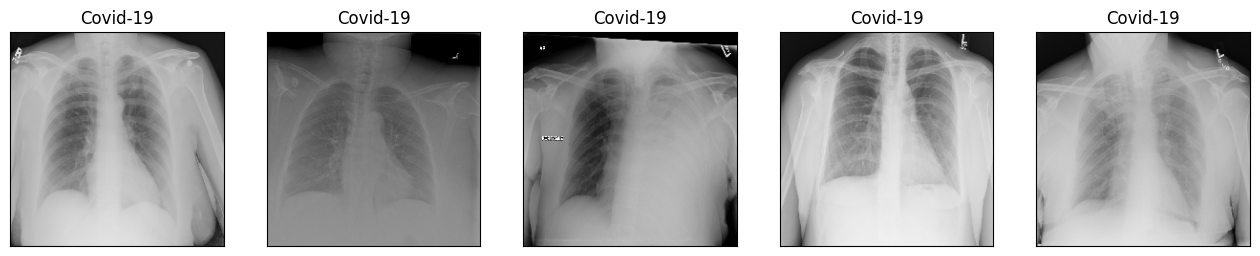

In [9]:
#Let's look at first 5 training data.
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [10]:
"""
   After that data is converted into Numpy array, Now,
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :)
no_of_classes = len(np.unique(y))
no_of_classes

2

In [11]:
y

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,

 ### Let's converts a class vector (integers) to binary class matrix

In [12]:
# Import to_categorical from tensorflow.keras.utils
from tensorflow.keras.utils import to_categorical

# Assuming you already have 'y' and 'no_of_classes' defined
y = to_categorical(y, num_classes=no_of_classes)
print(y[0])  # Print the one-hot encoded label for the first data point


[0. 1.]


### Split the data into train, test and valid subsets
> Here we are going to split our dataset into **80% train**, **10% validation**, and **10% test**.

In [13]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  500
The validation Data Shape  63
The test Data Shape  62


In [14]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


> **(224, 224, 3)** refers to the shape of the data (images) that will be fed into our CNN

---

### **CNN Implementation**

In [15]:
VGG19_model = keras.applications.VGG19(input_shape= X_train.shape[1:], include_top=False, weights="imagenet")
# setting the VGG model to be untrainable.
VGG19_model.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [16]:
VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
from keras.layers import BatchNormalization
Model = Sequential()
Model.add(VGG19_model)
Model.add(BatchNormalization())
Model.add(Dropout(0.20))
Model.add(Flatten())
Model.add(Dense(256,activation='relu'))
Model.add(Dense(2,activation='softmax'))
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

In [18]:
lr = 1e-4
bs = 8
optimizer = Adam(lr=1e-4)
Model.compile(optimizer, loss = 'binary_crossentropy' , metrics = ['accuracy'])

### **Modelling**


In [19]:
# Time to train our model !
epochs = 50

#initialize the training data augmentation object
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

checkpointer = ModelCheckpoint(filepath = "/gdrive/My Drive/covid19_detection.h5", save_best_only = True, verbose=1)
start = time.time()

# let's get started !

history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])

end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/50


<ipython-input-19-c61b5a7ee950>:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


62/62 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.8862
Epoch 1: val_loss improved from inf to 0.16709, saving model to /gdrive/My Drive/covid19_detection.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 22s 192ms/step - loss: 0.6670 - accuracy: 0.8862 - val_loss: 0.1671 - val_accuracy: 0.9365
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9472
Epoch 2: val_loss improved from 0.16709 to 0.14114, saving model to /gdrive/My Drive/covid19_detection.h5
62/62 [==============================] - 10s 159ms/step - loss: 0.2025 - accuracy: 0.9472 - val_loss: 0.1411 - val_accuracy: 0.9524
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.9614
Epoch 3: val_loss did not improve from 0.14114
62/62 [==============================] - 8s 123ms/step - loss: 0.1286 - accuracy: 0.9614 - val_loss: 0.1555 - val_accuracy: 0.9524
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9654
Epoch 4: val_loss improved from 0.14114 to 0.11411, saving model to /gdrive/My Drive/covid19_detection.h5
62/62 [==============================] - 14s 223ms/step - loss: 

### **Evaluation**


In [20]:
(eval_loss, eval_accuracy) = Model.evaluate(
     X_test, y_test, batch_size=bs, verbose=2)

print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

8/8 - 2s - loss: 0.0046 - accuracy: 1.0000 - 2s/epoch - 279ms/step
Accuracy: 100.00%
Loss: 0.004578706342726946


### Accuracy and Loss graphs

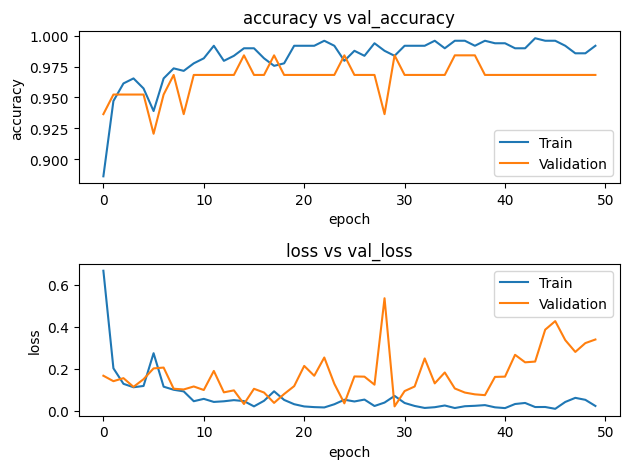

In [21]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt
def plot(history):
    plt.figure(1)
     # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy vs val_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

     # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss vs val_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

# Finaly, let's call the plot function with the 'result' parameter

plot(history)

### **Prediction**


2/2 [==============================] - 10s 5s/step


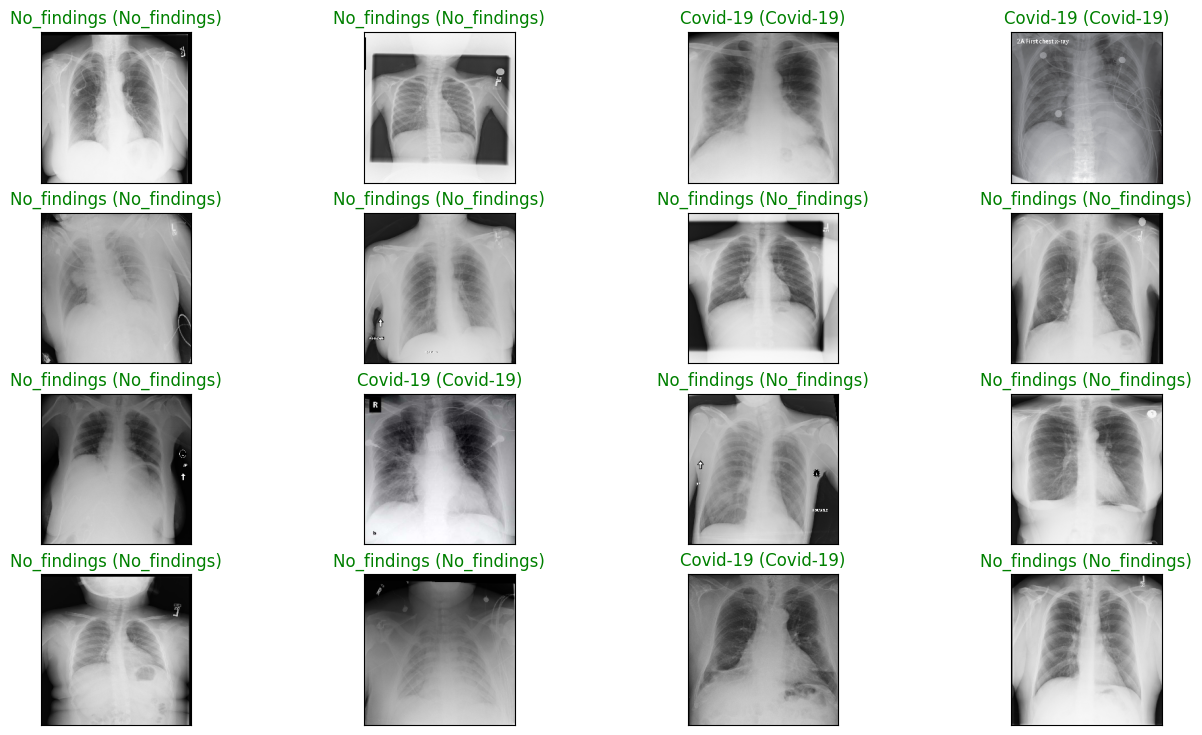

In [22]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(Model.predict(X_test))

### Confusion Matrix


2/2 [==============================] - 0s 187ms/step


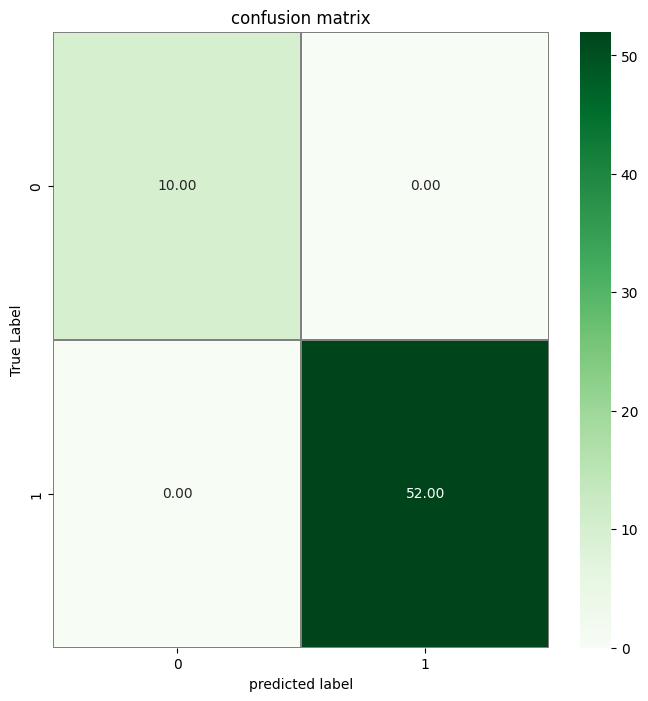

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [24]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

    Covid-19       1.00      1.00      1.00        10
 No_findings       1.00      1.00      1.00        52

    accuracy                           1.00        62
   macro avg       1.00      1.00      1.00        62
weighted avg       1.00      1.00      1.00        62



### Loading the model


In [26]:
my_model=keras.models.load_model("/gdrive/My Drive/covid19_detection.h5")

2/2 [==============================] - 0s 179ms/step


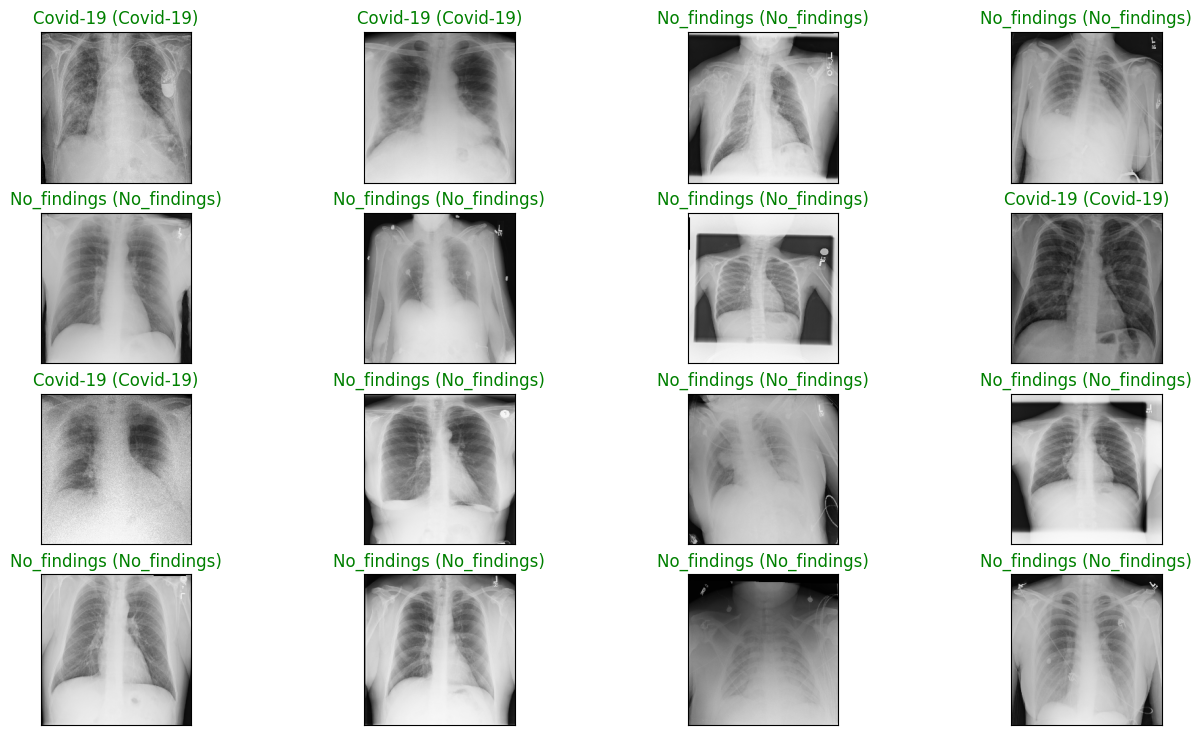

In [27]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))